In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [2]:
tf.__version__

'2.13.0'

# Specify each path

In [3]:
dataset = 'model/keypoint_classifier/keypoint.csv'
testset = 'model/keypoint_classifier/keypoint_test.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [4]:
NUM_CLASSES = 10

# Dataset reading


## Giá trị của dữ liệu

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

## Nhãn của dữ liệu

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

## Dữ liệu test

In [7]:
#X_unseen = np.loadtxt(testset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [8]:
#y_unseen = np.loadtxt(testset, delimiter=',', dtype='int32', usecols=(0))

## Chia tập dữ liệu

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.9, random_state=RANDOM_SEED)
X_train, X_val, y_train, y_val = train_test_split(X_dataset, y_dataset, train_size=0.8, random_state=RANDOM_SEED)

# Model building

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [11]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
Total params: 1180 (4.61 KB)
Trainable params: 1180 (4.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [13]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [14]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
76/80 [===========================>..] - ETA: 0s - loss: 2.1073 - accuracy: 0.2324 
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.keras
80/80 [==============================] - 0s 2ms/step - loss: 2.0941 - accuracy: 0.2371 - val_loss: 1.7126 - val_accuracy: 0.3928
Epoch 2/1000
 1/80 [..............................] - ETA: 0s - loss: 1.8279 - accuracy: 0.3672
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.keras
80/80 [==============================] - 0s 1ms/step - loss: 1.6127 - accuracy: 0.3916 - val_loss: 1.2375 - val_accuracy: 0.5695
Epoch 3/1000
 1/80 [..............................] - ETA: 0s - loss: 1.4293 - accuracy: 0.5078
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.keras
80/80 [==============================] - 0s 1ms/step - loss: 1.2938 - accuracy: 0.5189 - val_loss: 0.9072 - val_accuracy: 0.8201
Epoch 4/1000
 1/80 [..............................] - ETA: 0s - loss: 1.2377 - accuracy: 0.51

In [15]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_val, y_val, batch_size=128)

20/20 [==============================] - 0s 526us/step - loss: 0.0608 - accuracy: 0.9863


In [16]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [17]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))


1/1 [==============================] - 0s 39ms/step
[3.6119497e-03 1.4320534e-11 1.7029450e-27 8.6948217e-04 1.4176273e-02
 7.8332869e-06 1.4126296e-22 9.8126203e-01 1.5723326e-33 7.2413772e-05]
7


In [18]:
# Checking data and label
print(X_test[0])
print(y_test[0])

[ 0.          0.         -0.07142857 -0.14732143 -0.04464286 -0.35714287
  0.09821428 -0.42410713  0.25892857 -0.375       0.28125    -0.58928573
  0.51339287 -0.79910713  0.67410713 -0.90625     0.81696427 -1.
  0.39732143 -0.4732143   0.36160713 -0.5089286   0.19642857 -0.40625
  0.13839285 -0.35714287  0.45089287 -0.3392857   0.3392857  -0.32589287
  0.17410715 -0.25892857  0.12946428 -0.24553572  0.4642857  -0.20089285
  0.30357143 -0.17410715  0.16071428 -0.13392857  0.125      -0.13392857]
7


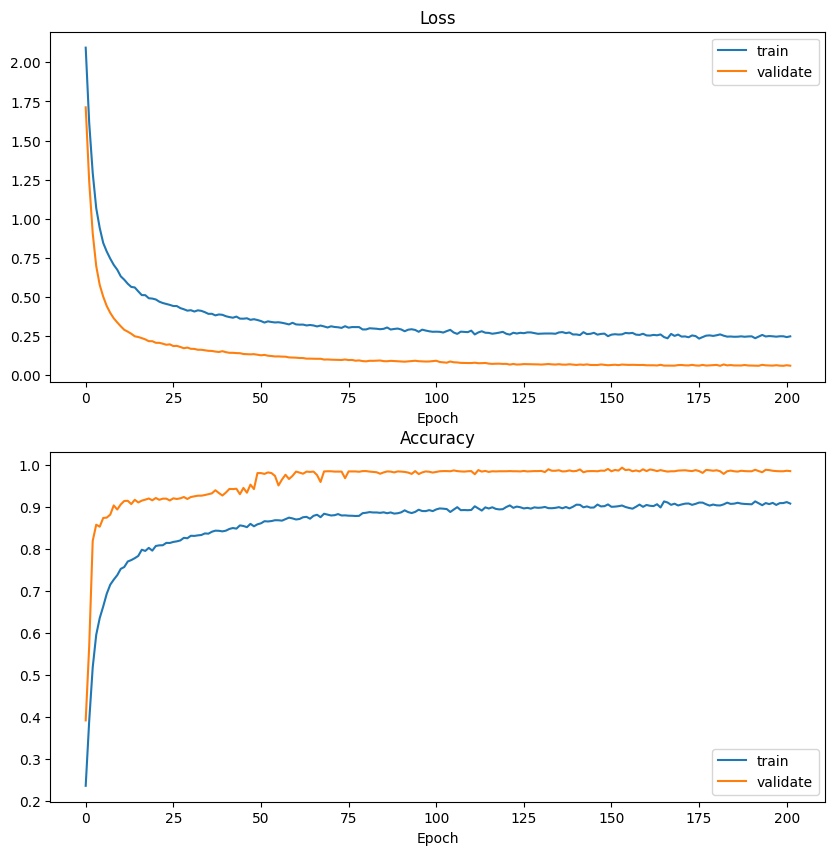

In [19]:
from matplotlib import pyplot
pyplot.subplots(nrows = 2, ncols = 1, figsize=(10, 10))

# Graph to show loss value over time during training (both training set and validating set)
pyplot.subplot(2, 1, 1)
pyplot.title('Loss')
pyplot.xlabel('Epoch')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validate')
pyplot.legend()
# Graph to show accuracy value over time during training (both training set and validating set)
pyplot.subplot(2, 1, 2)
pyplot.title('Accuracy')
pyplot.xlabel('Epoch')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='validate')
pyplot.legend()
pyplot.show()

# Confusion matrix

40/40 [==============================] - 0s 359us/step


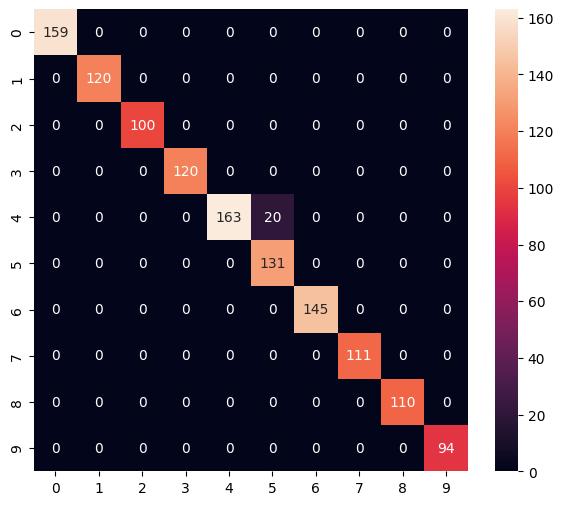

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       159
           1       1.00      1.00      1.00       120
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       120
           4       1.00      0.89      0.94       183
           5       0.87      1.00      0.93       131
           6       1.00      1.00      1.00       145
           7       1.00      1.00      1.00       111
           8       1.00      1.00      1.00       110
           9       1.00      1.00      1.00        94

    accuracy                           0.98      1273
   macro avg       0.99      0.99      0.99      1273
weighted avg       0.99      0.98      0.98      1273



In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)



80/80 [==============================] - 0s 342us/step


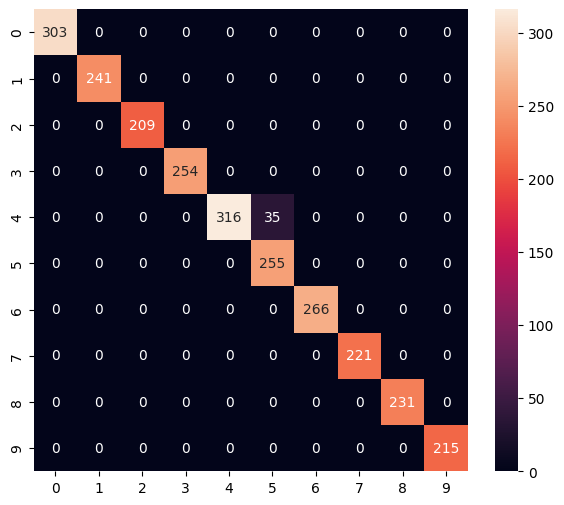

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       303
           1       1.00      1.00      1.00       241
           2       1.00      1.00      1.00       209
           3       1.00      1.00      1.00       254
           4       1.00      0.90      0.95       351
           5       0.88      1.00      0.94       255
           6       1.00      1.00      1.00       266
           7       1.00      1.00      1.00       221
           8       1.00      1.00      1.00       231
           9       1.00      1.00      1.00       215

    accuracy                           0.99      2546
   macro avg       0.99      0.99      0.99      2546
weighted avg       0.99      0.99      0.99      2546



In [31]:
Y_valpred = model.predict(X_val)
y_valpred = np.argmax(Y_valpred, axis=1)

print_confusion_matrix(y_val, y_valpred)

# Convert to model for Tensorflow-Lite

In [22]:
# Save as a model dedicated to inference
# model.save(model_save_path, include_optimizer=False)
model.save(model_save_path)

In [23]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_ops = [
#                 tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
#                 tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
#             ]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp6xillspz\assets


INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp6xillspz\assets


6808

# Inference test

In [24]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [25]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [26]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [27]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [28]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.6119409e-03 1.4320534e-11 1.7029448e-27 8.6948124e-04 1.4176266e-02
 7.8332714e-06 1.4126298e-22 9.8126203e-01 1.5723444e-33 7.2413699e-05]
7
